# Signal & Risk Engine

**Goal.** Transform the cointegrated pairs into **tradeable signals**:
1) Build the spread $S_t = Y_t - (\alpha + \beta X_t)$ and its standardized version (z-score).
2) Define **entry**, **exit**, and **emergency stop** rules on $Z_t$.
3) Implement **volatility-targeted position sizing** (risk targeting).
4) Persist features needed for the backtest (next notebook).

**Why this matters**
- Trading on raw price differences is scale-dependent; z-scoring normalizes the spread.
- Fixed thresholds on $Z_t$ produce a clear, testable rule.
- Volatility targeting stabilizes risk so Sharpe is more interpretable across regimes.


We import the reusable functions from `helpers.py` (written in notebook 00).  
We also attach the current `/notebooks` folder to `sys.path` so imports always work.


In [28]:
# Make helpers importable from this /notebooks folder
import sys
from pathlib import Path
NB_DIR = Path.cwd()
if str(NB_DIR) not in sys.path:
    sys.path.insert(0, str(NB_DIR))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from helpers import spread, rolling_zscore, ewma_vol, target_size


We load:
- cleaned prices (`prices_interim.parquet`) prepared in notebook 00;
- the shortlist of pairs with (alpha, beta) produced in notebook 01.

Hyperparameters here define the **feature construction**, not trading backtest yet:
- `ROLL_WINDOW_Z`: rolling window to compute $Z_t$.
- `EWMA_SPAN_VOL`: span for EWMA volatility of the spread (later used by position sizing).
- `TARGET_ANNUAL_VOL` and `MAX_PAIR_WEIGHT`: defaults for position size *features* (we persist them, but the backtest can override).


In [29]:
DATA = NB_DIR.parent / "data"
INTERIM = DATA / "interim"

# Feature construction hyperparameters
ROLL_WINDOW_Z   = 60
EWMA_SPAN_VOL   = 20
TARGET_ANNUAL_VOL = 0.15   # 10% annualized risk target (feature default)
MAX_PAIR_WEIGHT   = 0.10   # cap per pair (feature default)

# Load data prepared earlier
PRICES  = pd.read_parquet(INTERIM / "prices_interim.parquet")
SELECTED = pd.read_parquet(INTERIM / "selected_pairs.parquet")
print("Prices:", PRICES.shape, "| Selected pairs:", SELECTED.shape)
SELECTED


Prices: (2475, 15) | Selected pairs: (5, 8)


,y,x,alpha,beta,adf_stat,p_value,half_life,n_obs
0,TSLA,XLP,-346.021602,8.444825,-3.898149,0.002049,85.155939,2475
1,KO,TSLA,36.056034,0.077242,-3.788443,0.003028,95.303207,2475
2,KO,MSFT,29.620229,0.080560,-3.659847,0.004715,66.768381,2475
3,AAPL,MSFT,0.882444,0.506784,-3.583161,0.006091,83.703819,2475
4,AAPL,KO,-159.485115,5.741369,-3.400109,0.010955,67.369958,2475


Given a selected pair $(Y, X)$ with OLS estimates $(\alpha, \beta)$ from notebook 01:

- **Spread:**  
  $$ S_t = Y_t - (\alpha + \beta X_t). $$

- **Standardized spread (z-score):**  
  $$ Z_t = \frac{S_t - \mu_t}{\sigma_t}, $$
  where $\mu_t$ and $\sigma_t$ are the rolling mean and std of $S$ over a window (e.g., 60 days).

**Interpretation**
- $Z_t \approx 0$: spread is near its recent mean (no edge).
- Large positive $Z_t$: $Y$ is “rich” vs $X$ → candidate to **short** $Y$ and **long** $X$ (short spread).
- Large negative $Z_t$: $Y$ is “cheap” vs $X$ → candidate to **long** $Y$ and **short** $X$ (long spread).


We illustrate with the **first** selected pair (index 0).  
For each pair we compute:
- `spread` $S_t$,
- `z` $Z_t$ using `ROLL_WINDOW_Z`,
- annualized EWMA volatility of $S_t$ (`vol_ann`),
- a **feature** for target-vol position size (`size_feature`) = clipped inverse-vol rule.

We will later repeat this for **all** pairs and persist results.


In [30]:
row = SELECTED.iloc[0]
y, x = row["y"], row["x"]
alpha, beta = float(row["alpha"]), float(row["beta"])

px = PRICES[[y, x]].dropna()
S  = spread(px[y], px[x], beta=beta, alpha=alpha)
Z  = rolling_zscore(S, window=ROLL_WINDOW_Z)
vol_ann = ewma_vol(S, span=EWMA_SPAN_VOL)
size_feature = target_size(vol_ann, TARGET_ANNUAL_VOL, MAX_PAIR_WEIGHT)

preview = pd.concat({"spread": S, "z": Z, "vol_ann": vol_ann, "size_feat": size_feature}, axis=1)
preview.dropna().tail(10)


,spread,z,vol_ann,size_feat
Date,,,,
2025-10-22,111.601261,0.932820,213.670856,0.000702
2025-10-23,124.904747,1.111930,212.856453,0.000705
2025-10-24,111.840410,0.869178,213.848214,0.000701
2025-10-27,129.442554,1.121408,220.200068,0.000681
2025-10-28,144.243948,1.320743,218.696524,0.000686
2025-10-29,160.826884,1.538234,218.071765,0.000688
2025-10-30,140.092481,1.161001,239.240470,0.000627
2025-10-31,158.410345,1.417136,240.837792,0.000623
2025-11-03,175.287225,1.635966,237.977192,0.000630


Visual inspection is useful before coding the trading rules:
- The spread $S_t$ should look mean-reverting (oscillating).
- The z-score should cross thresholds a reasonable number of times (not every day).
- The `size_feature` should increase when volatility is low and shrink when high.


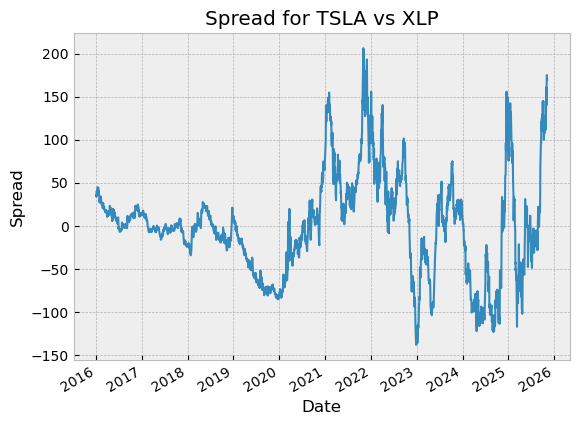

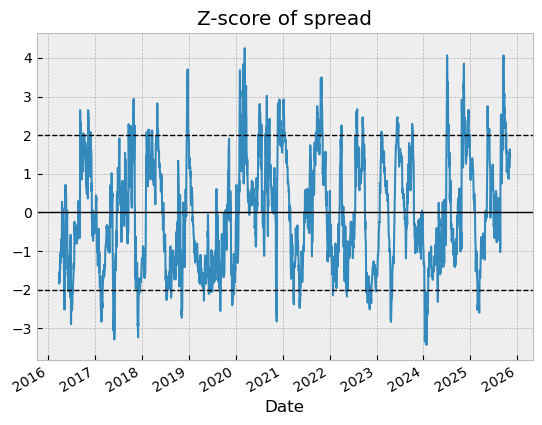

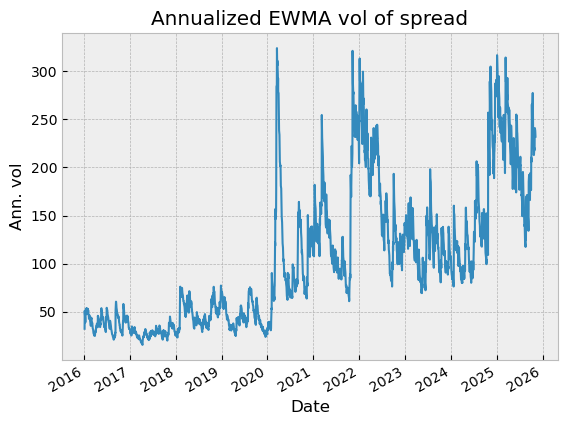

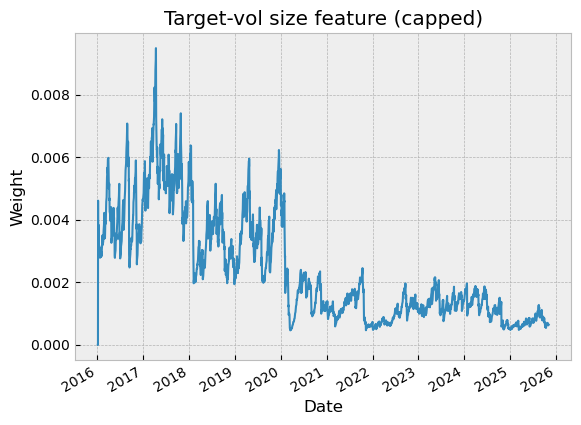

In [31]:
plt.figure(); S.plot(lw=1.5, title=f"Spread for {y} vs {x}"); plt.xlabel("Date"); plt.ylabel("Spread"); plt.show()
plt.figure(); Z.plot(lw=1.5, title="Z-score of spread"); plt.axhline(0, c='k', lw=1); \
    plt.axhline(2, linestyle="--", c='k', lw=1); plt.axhline(-2, linestyle="--", c='k', lw=1); plt.show()
plt.figure(); vol_ann.plot(lw=1.5, title="Annualized EWMA vol of spread"); plt.ylabel("Ann. vol"); plt.show()
plt.figure(); size_feature.plot(lw=1.5, title="Target-vol size feature (capped)"); plt.ylabel("Weight"); plt.show()


We define **parameterized** rules on $Z_t$.

**Entry**
- If $Z_t \ge z_{\text{open}}$: enter **short spread** (short $Y$, long $X$).
- If $Z_t \le -z_{\text{open}}$: enter **long spread** (long $Y$, short $X$).

**Exit**
- If $|Z_t| \le z_{\text{close}}$: close positions (mean reversion achieved).
- **Emergency stop** if $|Z_t| \ge z_{\text{stop}}$ (spread extended too far).
- **Time stop** after $D_{\max}$ days in a trade, to avoid stagnation.

These are **signals only**. The **backtest** will turn them into P&L using spread changes and costs.
We store the chosen defaults here as metadata for consistency across notebooks.


In [32]:
# Default rule parameters (can be tuned in 03_backtest_IS_OOS)
Z_OPEN        = 2.0
Z_CLOSE       = 0.5
Z_STOP        = 3.5
MAX_HOLD_DAYS = 20

rule_params = {
    "z_open": Z_OPEN,
    "z_close": Z_CLOSE,
    "z_stop": Z_STOP,
    "max_hold_days": MAX_HOLD_DAYS,
    "roll_window_z": ROLL_WINDOW_Z,
    "ewma_span_vol": EWMA_SPAN_VOL,
    "target_ann_vol": TARGET_ANNUAL_VOL,
    "max_pair_weight": MAX_PAIR_WEIGHT
}
rule_params


{'z_open': 2.0,
 'z_close': 0.5,
 'z_stop': 3.5,
 'max_hold_days': 20,
 'roll_window_z': 60,
 'ewma_span_vol': 20,
 'target_ann_vol': 0.15,
 'max_pair_weight': 0.1}

We now compute and **persist** per-pair feature panels so the backtest notebook can run without recomputing.

For each pair $(Y,X)$ we save a Parquet with columns:
- `spread`, `z`, `vol_ann`, `size_feat`
- index = dates

Files are written under:
`data/interim/features_{Y}-{X}.parquet`


In [33]:
written = []
for _, r in SELECTED.iterrows():
    y, x = r["y"], r["x"]
    a, b = float(r["alpha"]), float(r["beta"])
    df = PRICES[[y, x]].dropna()
    S = spread(df[y], df[x], beta=b, alpha=a)
    Z = rolling_zscore(S, window=ROLL_WINDOW_Z)
    V = ewma_vol(S, span=EWMA_SPAN_VOL)
    SZ = target_size(V, TARGET_ANNUAL_VOL, MAX_PAIR_WEIGHT)

    panel = pd.concat({"spread": S, "z": Z, "vol_ann": V, "size_feat": SZ}, axis=1)
    out_path = INTERIM / f"features_{y}-{x}.parquet"
    panel.to_parquet(out_path)
    written.append(out_path.name)

print("Feature files written:", len(written))
written[:5]


Feature files written: 5


['features_TSLA-XLP.parquet',
 'features_KO-TSLA.parquet',
 'features_KO-MSFT.parquet',
 'features_AAPL-MSFT.parquet',
 'features_AAPL-KO.parquet']

Too many crossings → overtrading; too few → opportunity starvation.  
A quick diagnostic: count how often $|Z_t|$ exceeds `z_open` for each pair.


In [34]:
crossings = []
for _, r in SELECTED.iterrows():
    y, x = r["y"], r["x"]
    feat = pd.read_parquet(INTERIM / f"features_{y}-{x}.parquet")
    z = feat["z"].dropna()
    n = int(((z >= Z_OPEN) | (z <= -Z_OPEN)).sum())
    crossings.append({"pair": f"{y}-{x}", "n_crossings": n, "n_days": int(z.size)})

diag = pd.DataFrame(crossings).sort_values("n_crossings", ascending=False)
diag.head(10)


,pair,n_crossings,n_days
0,TSLA-XLP,357,2416
1,KO-TSLA,345,2416
3,AAPL-MSFT,336,2416
2,KO-MSFT,335,2416
4,AAPL-KO,331,2416


To keep downstream notebooks consistent, we persist the **rule parameters** chosen here.
Backtests can still override them, but having a canonical set is useful for reproducibility.


In [35]:
meta = pd.Series(rule_params, name="rule_params").to_frame()
meta.to_parquet(INTERIM / "signal_risk_params.parquet")
pd.read_parquet(INTERIM / "signal_risk_params.parquet")


,rule_params
z_open,2.00
z_close,0.50
z_stop,3.50
max_hold_days,20.00
roll_window_z,60.00
ewma_span_vol,20.00
target_ann_vol,0.15
max_pair_weight,0.10


# Summary

**What we built**
- The spread $S_t$ and standardized spread $Z_t$ for each selected pair.
- A volatility estimate `vol_ann` (EWMA) and a **target-vol position size feature** `size_feat`.
- Parameterized **entry/exit/stop** rules for $Z_t$ (saved as metadata).
- Persisted per-pair feature panels to `data/interim/features_{Y}-{X}.parquet`.

**Why this matters**
- Z-score transforms the spread to a comparable scale, enabling consistent thresholds.
- Volatility targeting aligns position size with current risk, stabilizing portfolio behavior.

**Next notebook — 03: Backtest (IS/OOS)**
- Use these features to simulate trades:
  - build positions from $Z_t$ and rule parameters,
  - apply `size_feat` for risk scaling,
  - compute P&L from $\Delta S_t$,
  - add realistic costs,
  - evaluate IS vs OOS performance.
